# **Final Project**

## **Introduction**

### Project Overview

In the rapidly evolving landscape of retail and e-commerce, leveraging data to forecast profits is not just an advantage but a necessity. This project aims to harness the power of machine learning, specifically through the use of XGBoost, a leading gradient boosting framework, to predict profits from a comprehensive dataset provided by a superstore. The dataset encompasses various aspects of sales transactions, including product details, sales figures, profits, and customer information, meticulously cleaned and prepared for analysis.

### Business Context

Understanding and predicting profits enable businesses to make informed decisions, optimize operations, and enhance customer satisfaction. By accurately forecasting profit margins, the superstore can identify lucrative products, tailor marketing strategies, manage inventory more effectively, and ultimately, drive growth. This project serves as a strategic tool, guiding the superstore in navigating market dynamics, competitive pressures, and customer preferences.

### Objective

The primary objective of this project is to develop a robust predictive model that can forecast profit margins with high accuracy. By doing so, we aim to provide actionable insights that will assist the superstore in strategic planning, resource allocation, and performance optimization.

### SMART Analysis

To ensure the project's objectives are clearly defined and achievable, we employ the SMART criteria:

- **Specific**: Develop a machine learning model using XGBoost to predict profits based on historical sales data. The model will consider variables such as product categories, sales channels (online or in-store), geographical regions, and customer segments.

- **Measurable**: Achieve a model with a prediction accuracy of at least 90% on the validation set, utilizing metrics such as RMSE (Root Mean Square Error) or MAE (Mean Absolute Error) for quantifying performance.

- **Achievable**: Given the comprehensive dataset and the proven capabilities of XGBoost in handling complex datasets and predictive tasks, developing a highly accurate predictive model is within reach.

- **Relevant**: This project aligns with the superstore's strategic goals of maximizing profits, optimizing inventory management, and enhancing customer satisfaction through data-driven decisions.

- **Time-bound**: The project will be completed in phases over a period of 3 months, starting from data preparation, model development, and testing, to final deployment and evaluation.

### Significance to the Business

By successfully predicting profits, the superstore can proactively manage its operations, refine its marketing strategies, and improve customer engagement. This project not only aims to bolster the bottom line but also to foster a culture of innovation and data-centric decision-making within the organization.

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import squarify
import matplotlib.cm as cm
import phik
import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xg
from xgboost import plot_importance
from feature_engine.outliers import Winsorizer

# Set pandas options
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable inline plotting
%matplotlib inline

## **Import Data**

The first step in our analysis involves loading the cleaned dataset from a CSV file. This dataset is a comprehensive collection of sales transactions from a superstore, including various attributes such as product details, sales figures, and profit margins. 

In [2]:
# Loading cleaned data from csv file
df=pd.read_csv('superstore_clean.csv')

Upon loading the data, it's essential to get a glimpse of its structure and the first few entries to understand the dataset's composition. Displaying the first five rows offers a preliminary view of the variables involved, such as order ID, order date, ship date, product category, sales, and profit, among others.

In [3]:
# Displaying the first five rows
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


The output reveals the dataset's first five transactions, showcasing columns like `order_id`, `order_date`, `ship_mode`, `segment`, `category`, `sales`, `quantity`, `discount`, and `profit`. For instance, the first row indicates a sale made on *November 8, 2016*, involving furniture (a bookcase) with **a sale amount of $261.96**, resulting in a ***profit of $41.9136***.

In [4]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         9994 non-null   int64  
 1   order_id       9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   ship_date      9994 non-null   object 
 4   ship_mode      9994 non-null   object 
 5   customer_id    9994 non-null   object 
 6   customer_name  9994 non-null   object 
 7   segment        9994 non-null   object 
 8   country        9994 non-null   object 
 9   city           9994 non-null   object 
 10  state          9994 non-null   object 
 11  postal_code    9994 non-null   int64  
 12  region         9994 non-null   object 
 13  product_id     9994 non-null   object 
 14  category       9994 non-null   object 
 15  sub_category   9994 non-null   object 
 16  product_name   9994 non-null   object 
 17  sales          9994 non-null   float64
 18  quantity

The dataset comprises 9994 entries across 21 columns, with data types ranging from integers and floats to objects (strings). Notably, there are **no null values** in any of the columns, indicating a well-maintained and clean dataset ready for analysis.

A statistical summary of the numerical fields in the dataset provides insights into the distribution of sales, profits, quantities, and discounts. This summary includes measures of central tendency and dispersion, such as mean, median, standard deviation, minimum, and maximum values.

In [5]:
# Displaying statistics for numerical data
df.describe()

,row_id,postal_code,sales,quantity,discount,profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


The statistical overview reveals key insights, such as the average sale amount being approximately $229.86, with a wide range of sales values indicated by the standard deviation of $623.25. Profits, on the other hand, have a mean of $28.66, but the standard deviation of $234.26 suggests significant variability. This summary underscores the dataset's diverse transactional dynamics, from small to large sales and profits, highlighting the potential for in-depth analysis on factors influencing sales and profitability.

## **Exploratory Data Analysis**

### Average Sales Across Different Regions

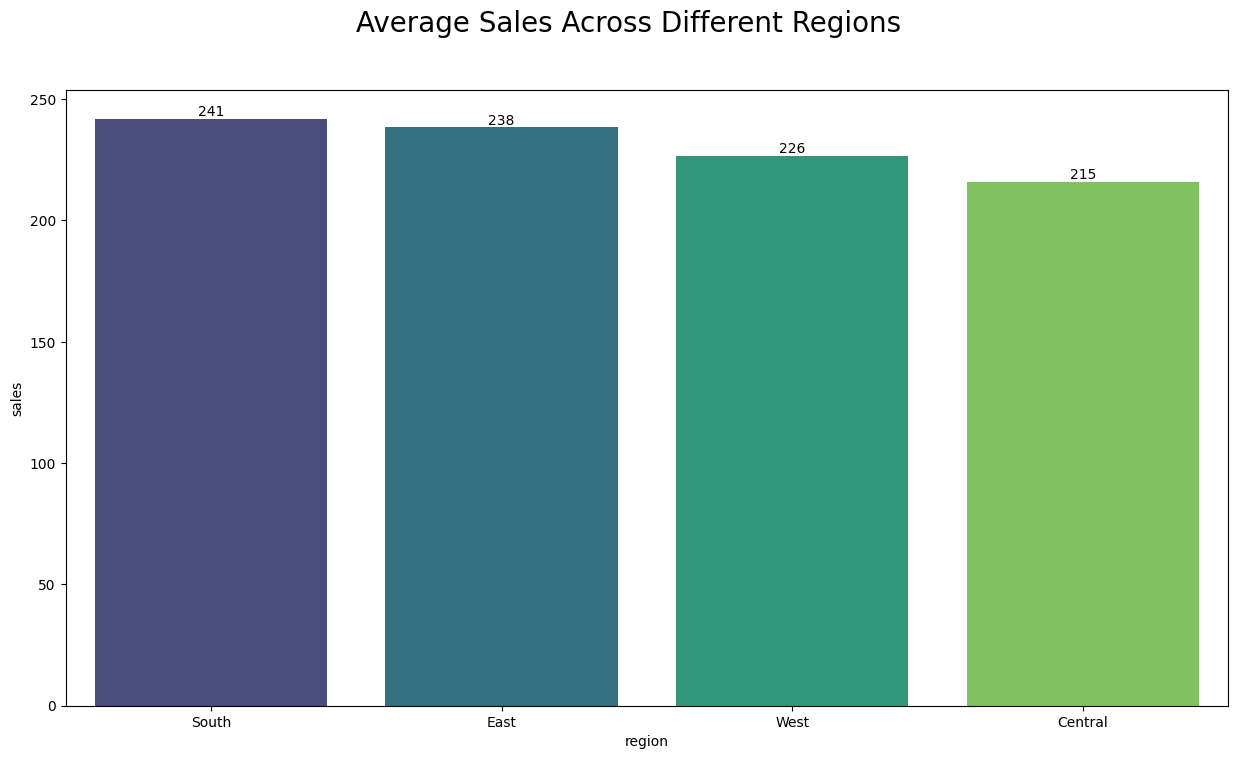

In [6]:
# Selecting features
df_bar = df[['region','sales']]
df_bar = df_bar.groupby('region').mean().sort_values(by='sales', ascending=False)

plt.figure(figsize=[15,8]) # Setting the figure size

plt.suptitle("Average Sales Across Different Regions", size=20, ha='center')  # Title is centered


# Plotting the BarChart with Seaborn
plt.subplot()
sns.barplot(x=df_bar.index, y='sales', data=df_bar, palette='viridis')

# Menambahkan label count ke dalam plot
for index, value in enumerate(df_bar['sales']):
    plt.text(index, value, str(int(value)), ha='center', va='bottom')

plt.show()


The bar chart visualizes the average sales across different regions, revealing how sales performance varies geographically. The chart indicates that the Central region has the highest average sales, followed by the South, East, and West regions. This insight suggests regional preferences or operational strengths that could influence strategic decisions such as inventory distribution, marketing focus, and resource allocation to optimize sales performance in underperforming regions.

### Average Sales and Profit Over Time

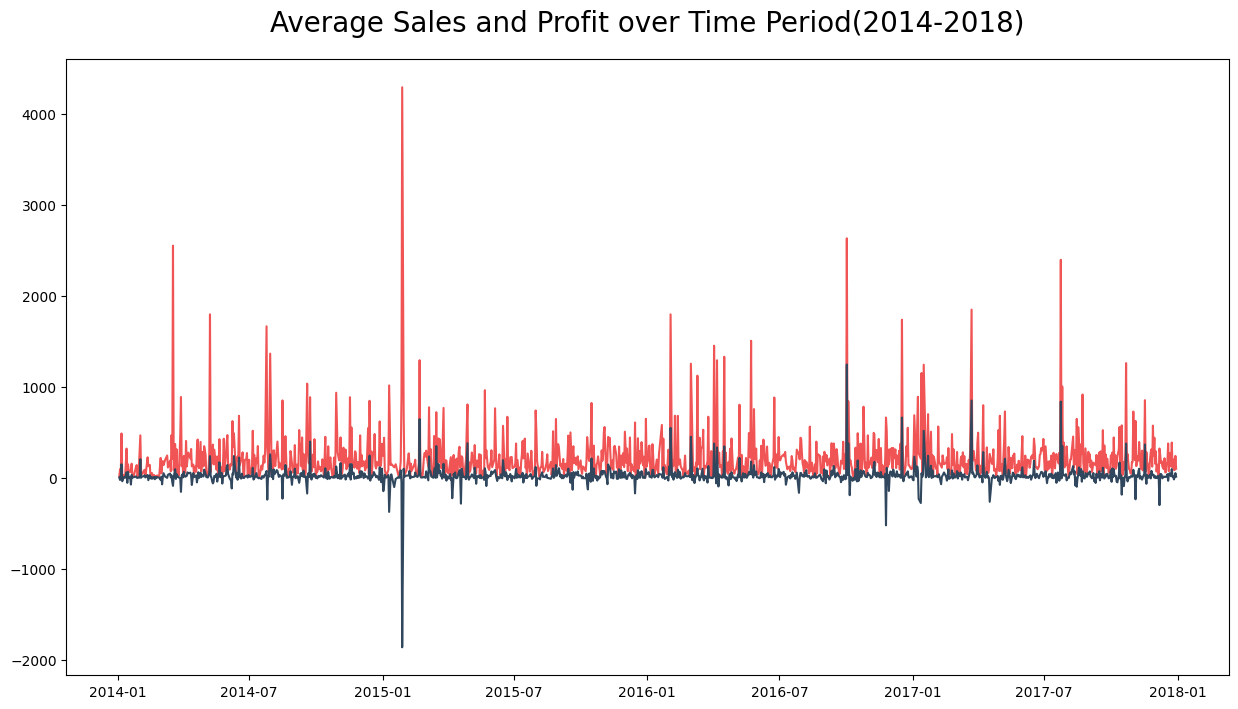

In [7]:
# First of all, we are going to take only the subset of data for our purpose. (To keep things simple)
df_line = df[['order_date','sales','profit']].sort_values('order_date') # Chronological Ordering
df_line['order_date'] = pd.to_datetime(df_line['order_date']) # Converting into DateTime
df_line = df_line.groupby('order_date').mean() # Groupby to get the average sales and profit on each day

# Visualizing the Line Chart
plt.figure(figsize=[15,8])
plt.plot(df_line.index, 'sales', data=df_line, color='#F05454') # Avg sales over Time
plt.plot(df_line.index, 'profit', data=df_line, color='#30475E') # Avg profit over Time
plt.title("Average Sales and Profit over Time Period(2014-2018)", size=20, pad=20)

plt.show()


The line chart presents a temporal view of average sales and profits from 2014 to 2018, offering insights into the store's financial health and sales trends over time. Notably, while sales exhibit seasonal peaks and troughs, profit trends might indicate underlying operational efficiencies or cost management strategies. The visualization underscores the importance of aligning sales strategies with cost control to enhance profitability.

### Segment vs. Region Distribution

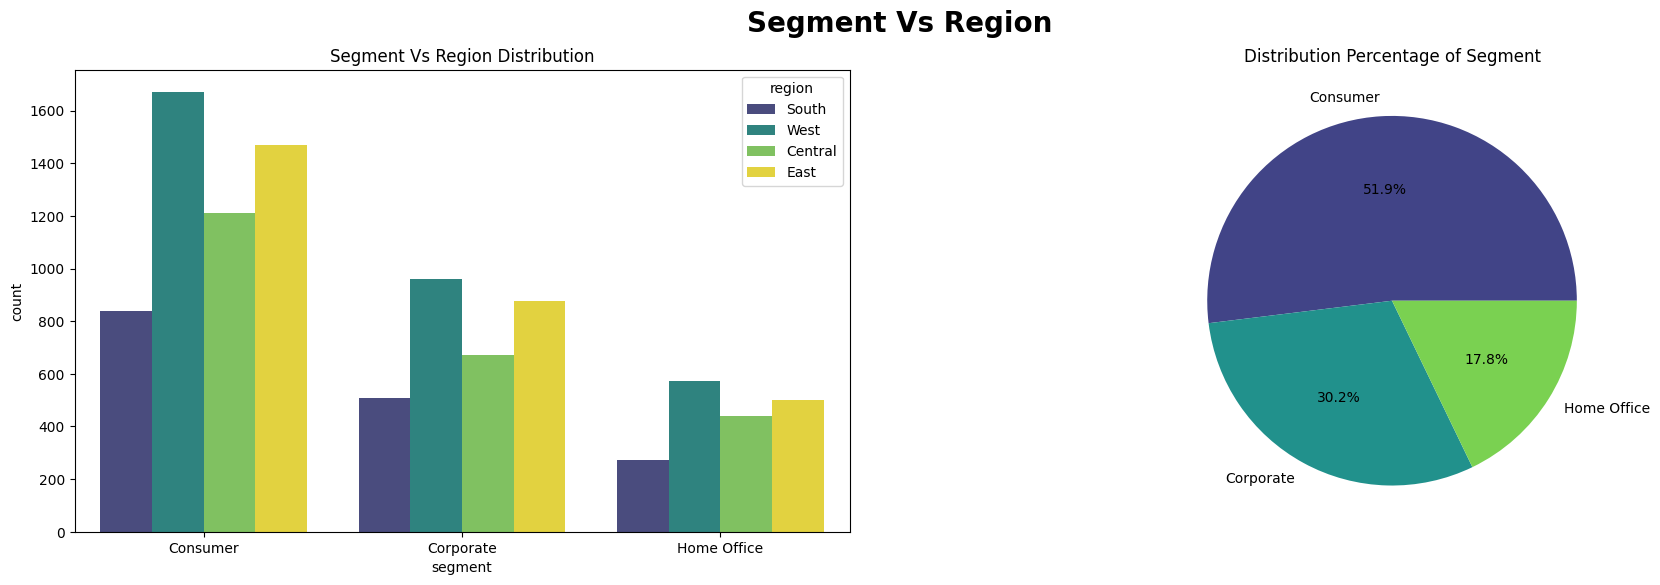

In [8]:
target_colors1 = plt.cm.viridis([0.2, 0.5, 0.8, 1.0])  # Membuat warna dari palet Viridis
# Membuat kotak dasar untuk chart
fig = plt.figure(figsize=(22,6))
plt.suptitle('Segment Vs Region',weight='bold',fontsize=20)
grid = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

# Membuat bar chart berisi count
ax1 = fig.add_subplot(grid[0,:1])
ax1.set_title('Segment Vs Region Distribution')
# Menggunakan seaborn untuk menggambar chart
sns.countplot(x='segment', data=df, ax=ax1, hue='region', palette=target_colors1)

# Mencoba membuat pie chart untuk melihat komposisi data cab_type
ax2 = fig.add_subplot(grid[0,1:])
ax2.set_title('Distribution Percentage of Segment')
# Memasukkan perhitungan values counts cab_type kedalam index
label = list(df['segment'].value_counts().index)
value = list(df['segment'].value_counts().values)

# Membuat pie chart
ax2.pie(value, labels=label, autopct='%1.1f%%', colors=target_colors1)
# Menunjukkan chart yang sudah dibuat
plt.show()

The count plot and pie chart illustrate the distribution of customer segments across different regions and the overall composition of these segments. The visual analysis reveals a balanced distribution of segments across regions, with a particular emphasis on the consumer segment's predominance. These insights can guide targeted marketing strategies and product offerings to cater to the dominant segments in each region.

### Category Composition for Profit and Sales

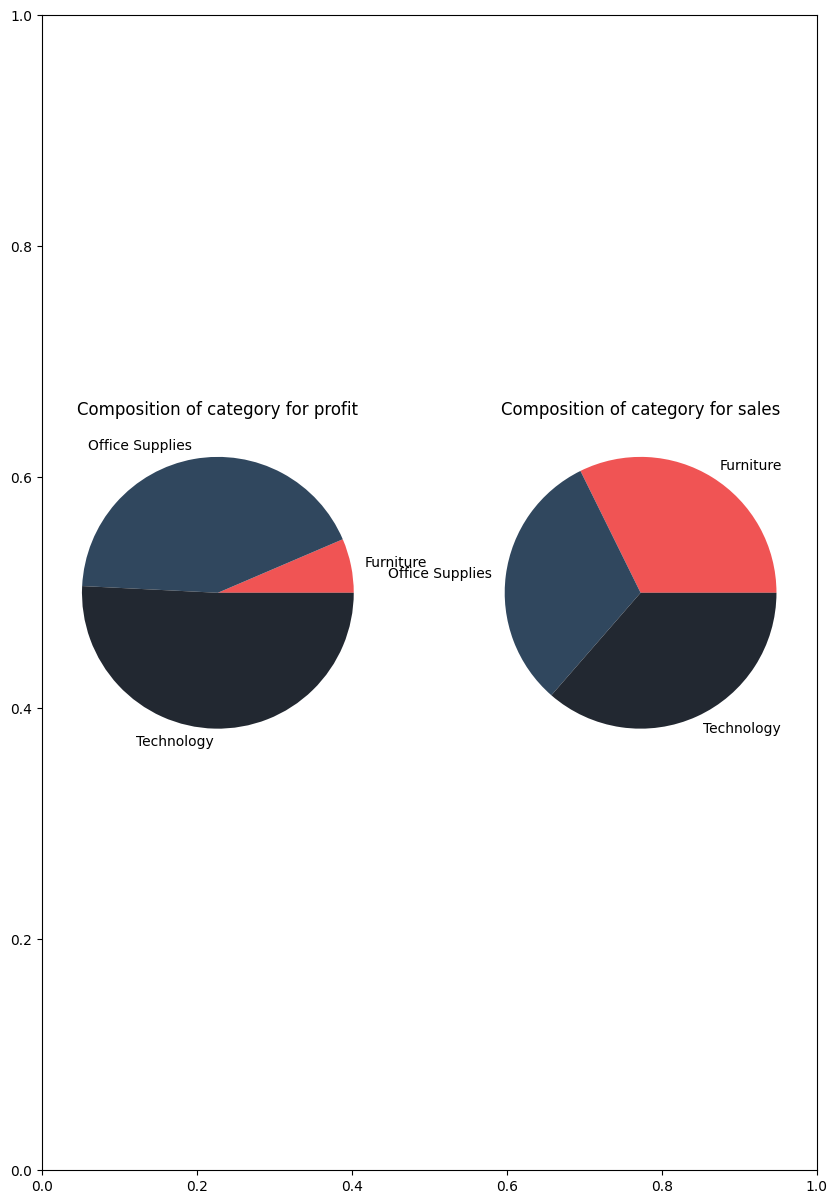

In [9]:
plt.figure(figsize=[10,15])
plt.subplot()

# Taking a subset of data (To keep things simple)
df_pie = df[['category','sales','profit']]
# taking a groupby on category and then ship_mode...
df_pie = df_pie.groupby(['category']).sum().reset_index()

# Visualizing the Pie Chart (profit)
plt.subplot(3,2,3)
plt.pie(df_pie['profit'], labels=df_pie['category'], colors=['#F05454','#30475E','#222831','#DDDDDD'])
plt.title("Composition of category for profit")

# Visualizing the Pie Chart (sales)
plt.subplot(3,2,4)
plt.pie(df_pie['sales'], labels=df_pie['category'], colors=['#F05454','#30475E','#222831','#DDDDDD'])
plt.title("Composition of category for sales")

plt.show()

Pie charts for profit and sales by category underscore the contribution of different product categories to the store's overall financial metrics. These charts reveal which categories are more profitable or generate higher sales, highlighting potential areas for inventory expansion or pricing strategy adjustments to maximize profitability and sales performance.

### Sales Across Shipping Modes

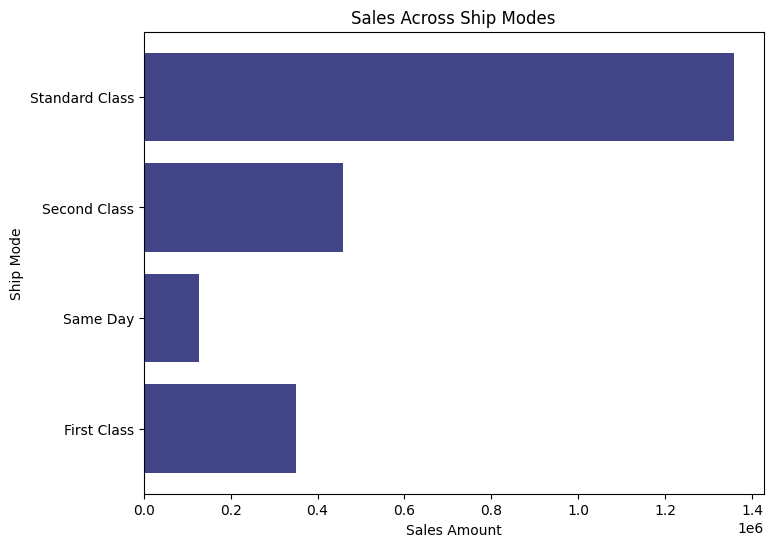

In [10]:
# Taking a subset of data (To keep things simple)
df_stackb = df[['ship_mode','sales','profit']]
# taking a groupby on category and then ship_mode...
df_stackb = df_stackb.groupby(['ship_mode']).sum().reset_index()

# Visualizing the Stacked BarChart
fig, ax = plt.subplots(figsize=(8, 6))

# Creating horizontal bar chart for sales
ax.barh(y=df_stackb['ship_mode'], width=df_stackb['sales'], color=plt.cm.viridis(0.2))
ax.set_title('Sales Across Ship Modes')
ax.set_xlabel('Sales Amount')
ax.set_ylabel('Ship Mode')

plt.show()

The horizontal bar chart depicting sales across different shipping modes provides insights into customer preferences and operational logistics. Identifying the most popular shipping modes can help streamline logistics operations, improve customer satisfaction, and potentially reduce costs through optimized shipping strategies.

### Sales vs. Profit Across Customer Segments

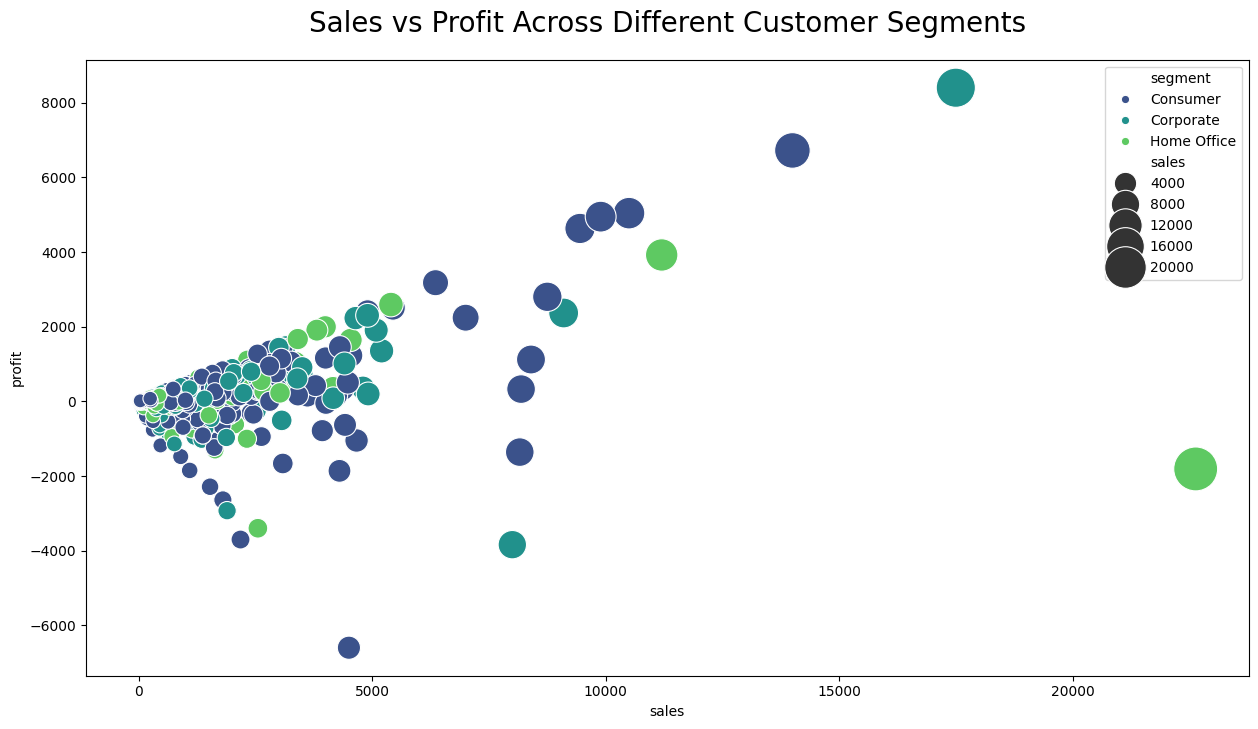

In [11]:
df_scatter = df[['sales','profit','segment']]

# Visualizing the ScatterPlot
plt.figure(figsize=[15,8])
# Profit in the Y axis, and Sales in the X. Hue will classify the dots according to Segment.
# The size of the dots are according to the volumen of "Sales".
sns.scatterplot(x=df_scatter['sales'], y=df_scatter['profit'], hue=df_scatter['segment'], palette='viridis', size=df_scatter["sales"], sizes=(100,1000), legend='auto') 
plt.title("Sales vs Profit Across Different Customer Segments", size=20, pad=20)
plt.show()

The scatter plot explores the relationship between sales and profit across different customer segments, with the size of each point representing the volume of sales. This visualization highlights the variability in profitability across different sales volumes and segments, suggesting that while some segments may generate higher sales, the associated profits vary significantly. This insight is crucial for refining segmentation strategies, product offerings, and pricing models to enhance profitability.

### Key Insights from the phi_k Correlation Analysis

interval columns not set, guessing: ['row_id', 'postal_code', 'sales', 'quantity', 'discount', 'profit']


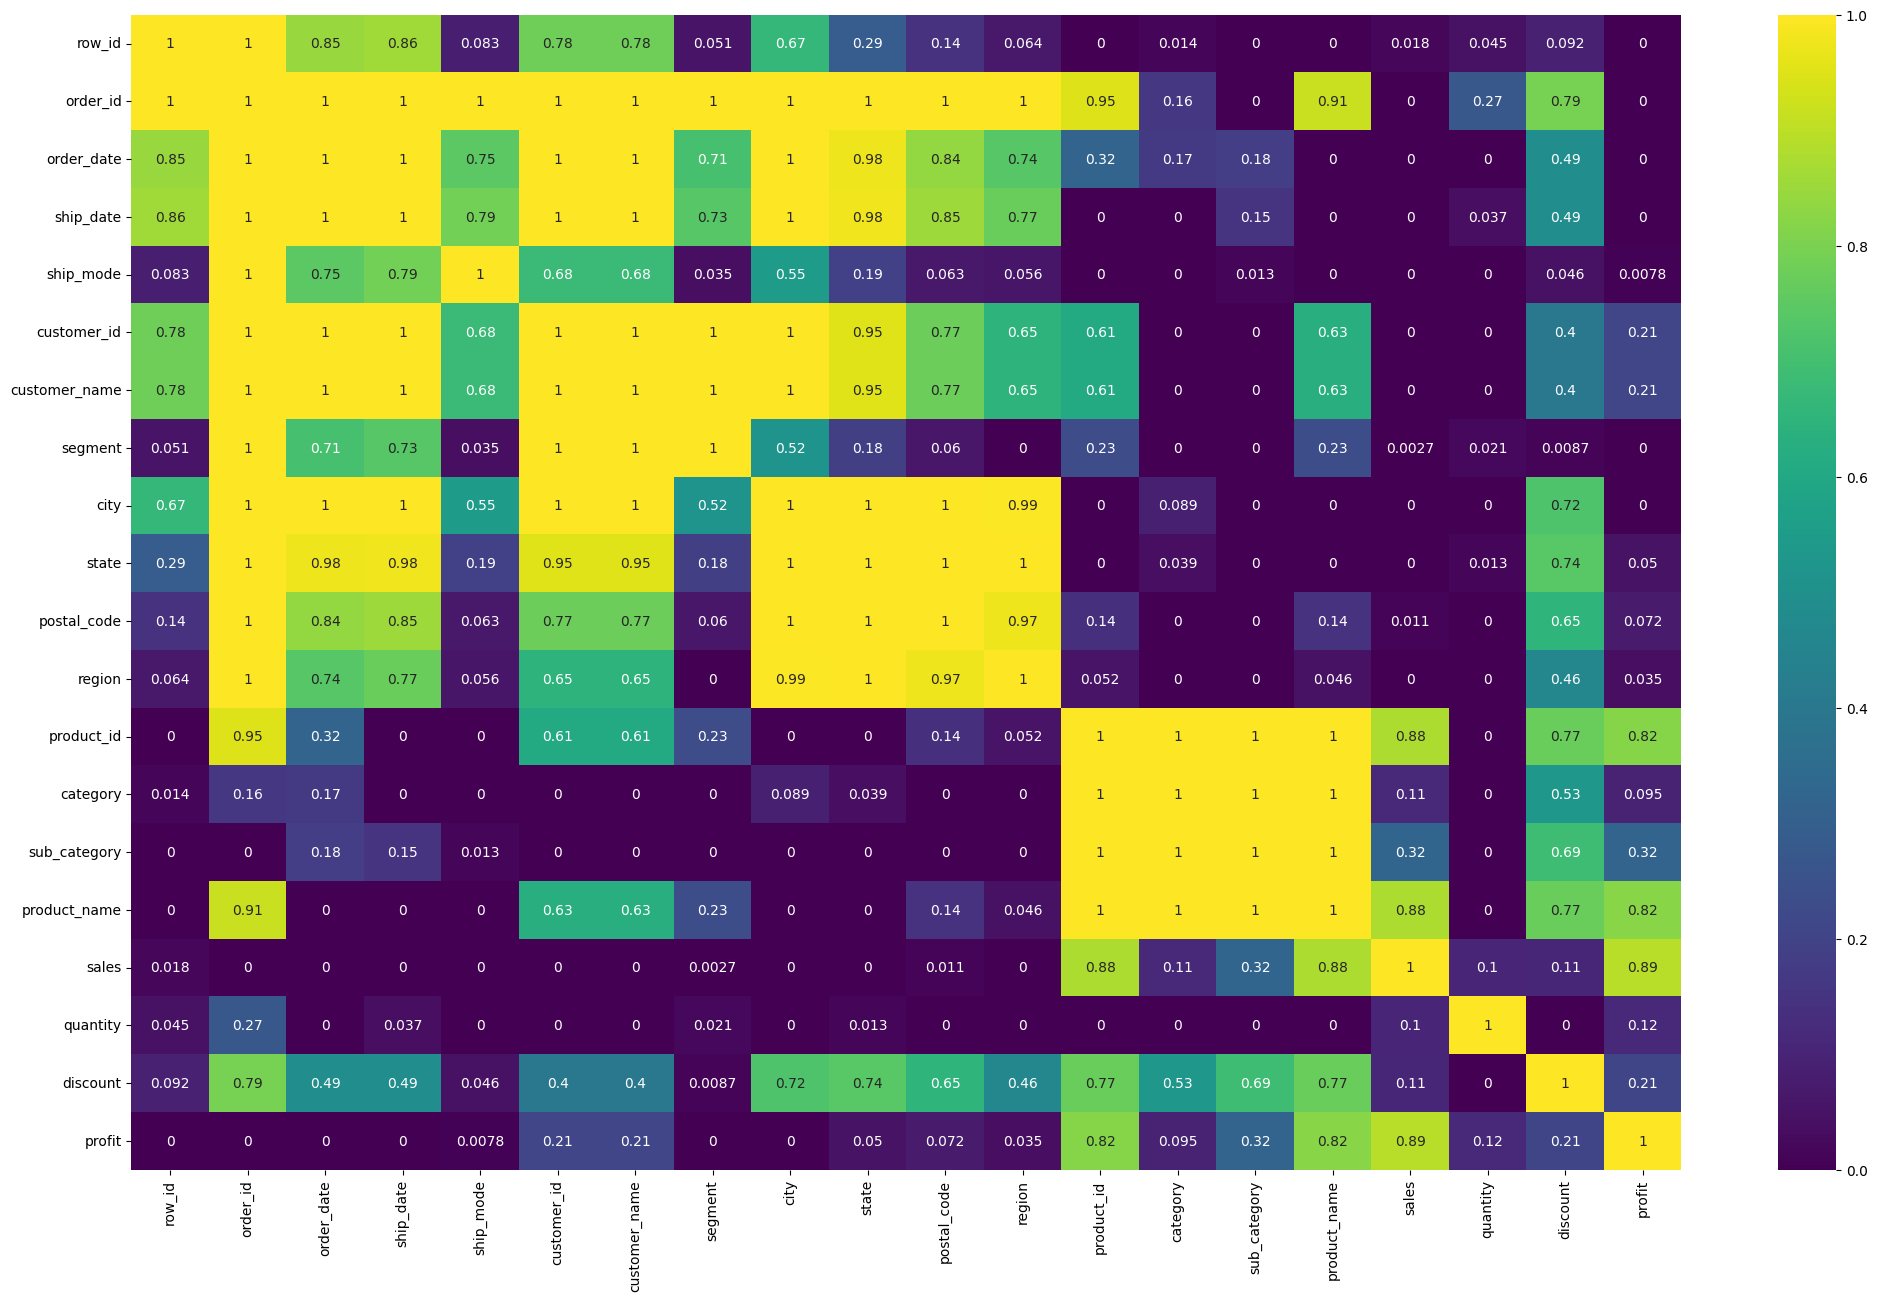

In [12]:
# Calculating the phik correlation matrix
df_phik = df.phik_matrix()

The phi_k correlation matrix provided offers a comprehensive overview of the relationships between various features of the superstore dataset. This analysis focuses on the significant correlations that could impact business strategies and decision-making processes.

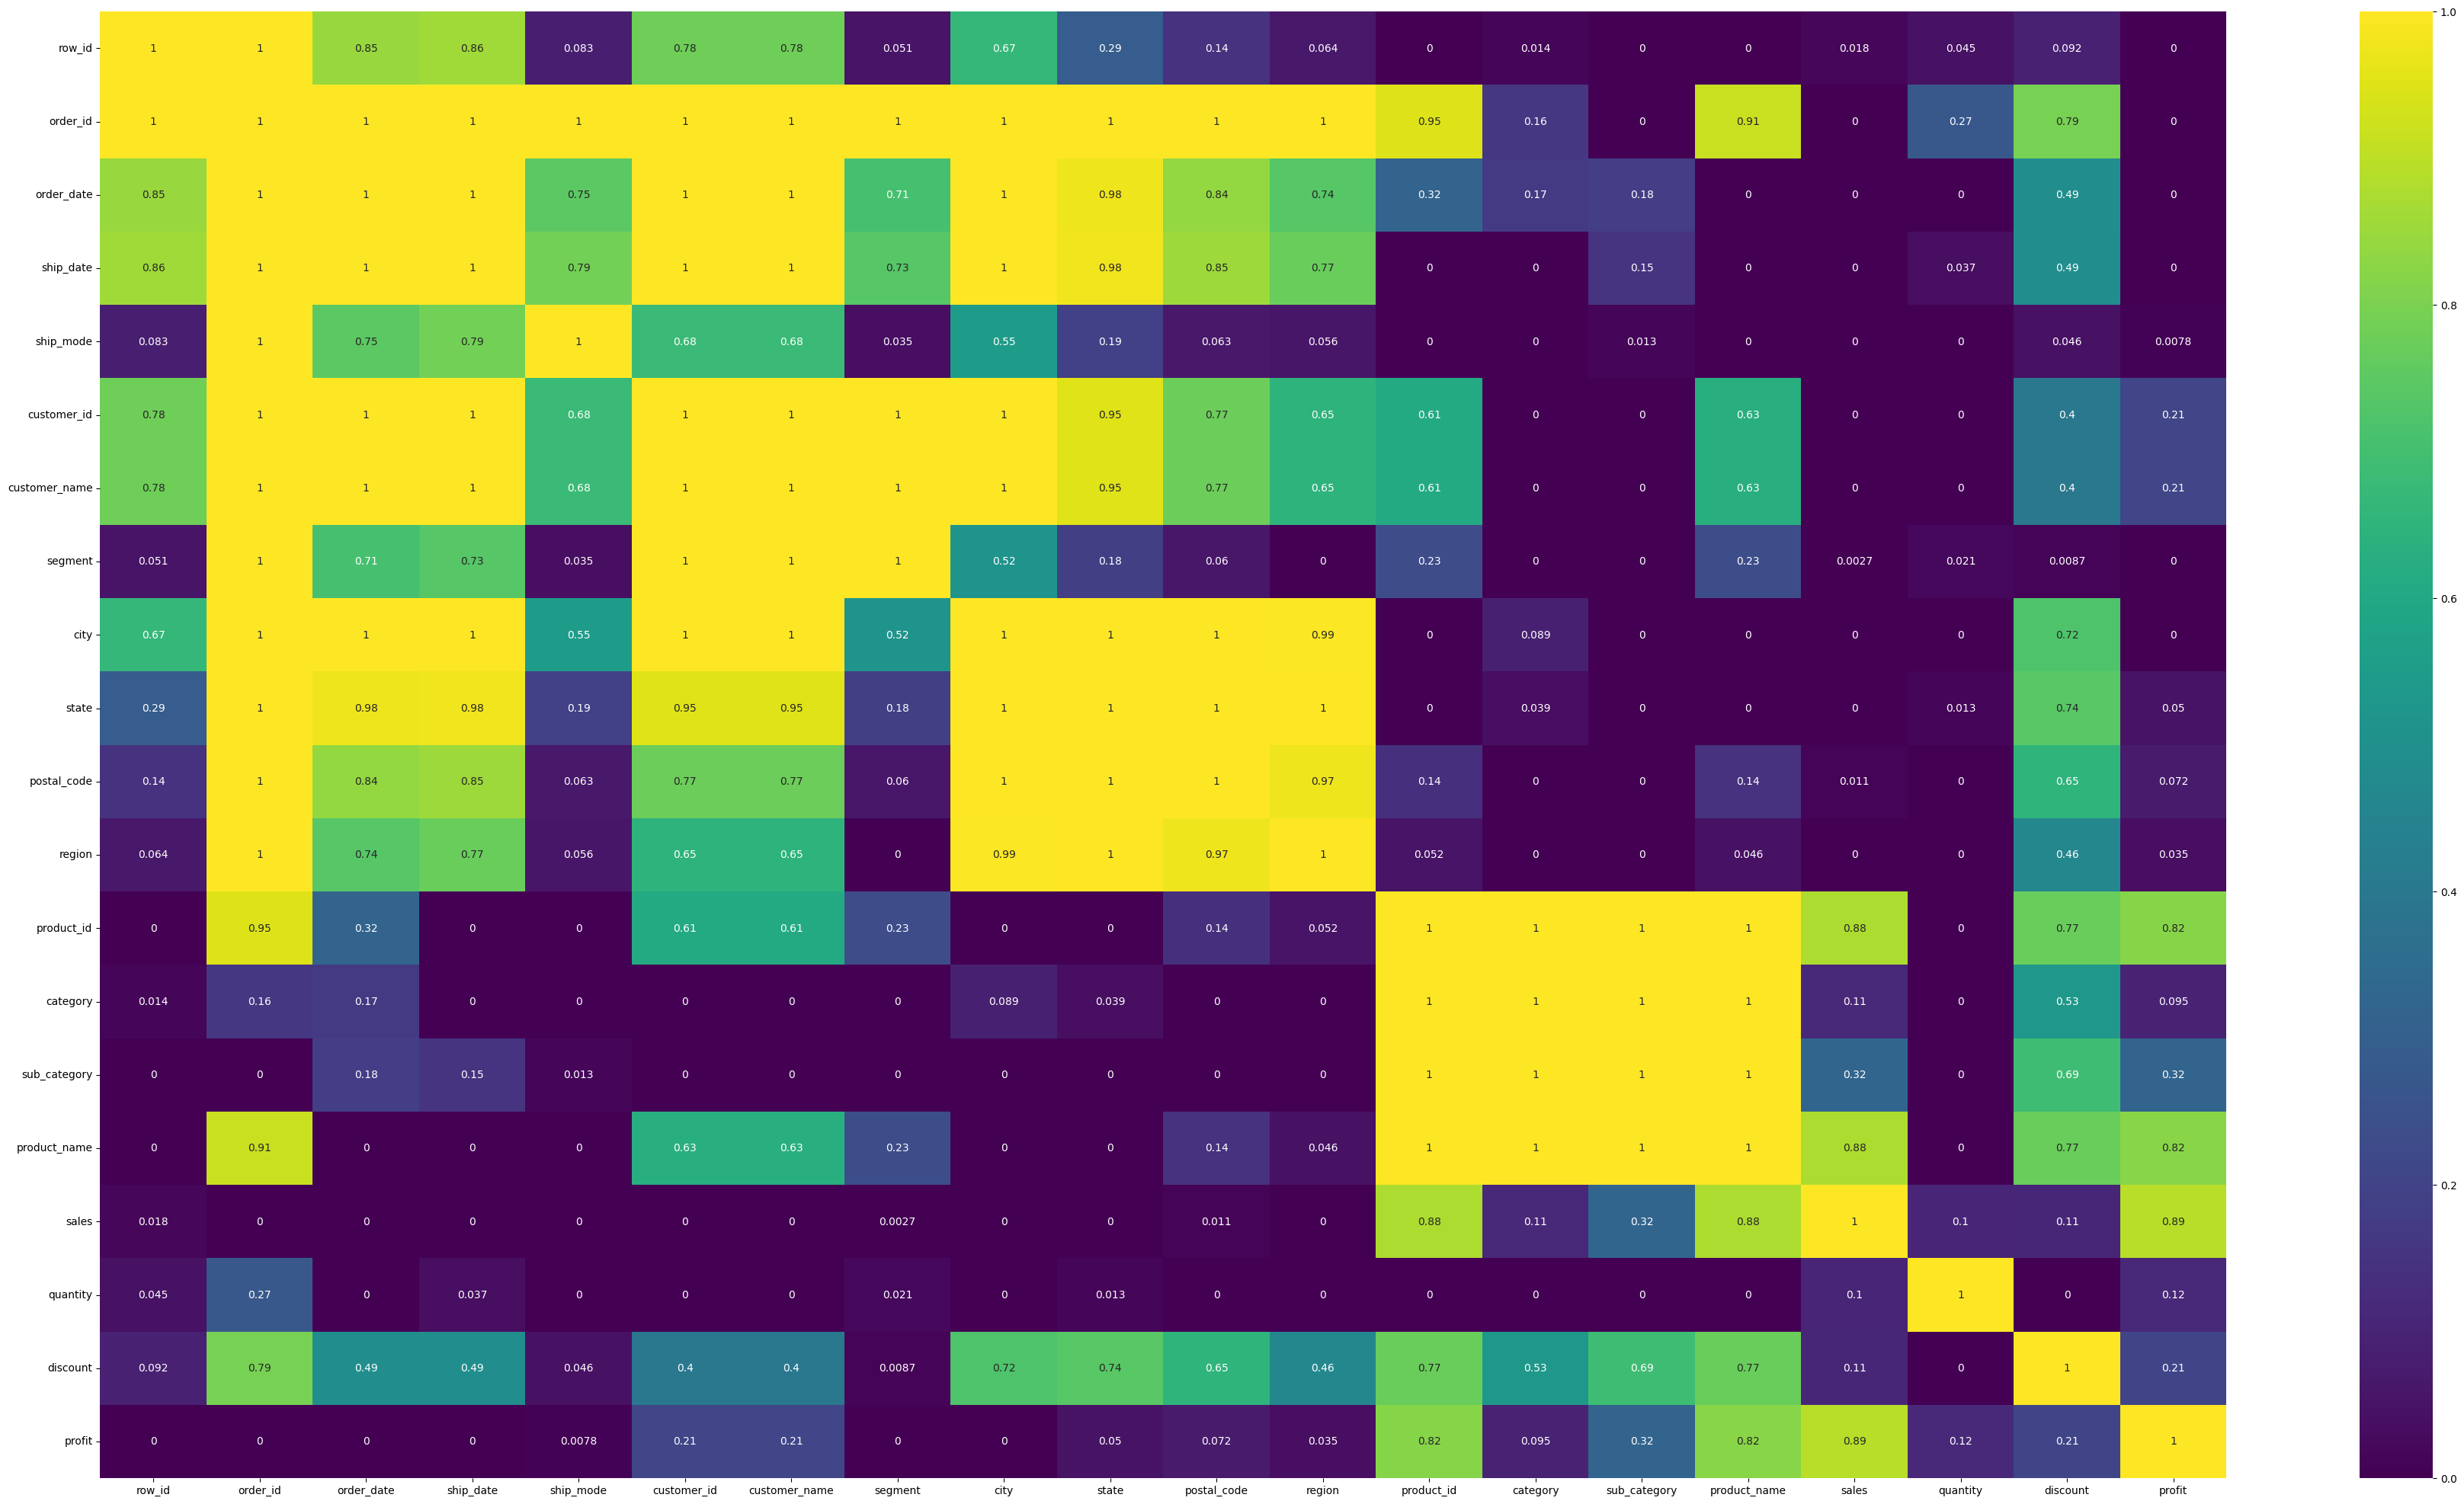

In [15]:
# Visualizing the phik correlation heatmap
plt.figure(figsize=(45,25))
sns.heatmap(df_phik, annot=True, cmap='viridis')
plt.show()

#### High Correlation between Order Attributes
- **Order Date and Ship Date** have almost perfect correlation (\(>0.99\)), indicating that the time between placing an order and shipping is consistent across the dataset. This consistency can be leveraged for optimizing logistics and ensuring customer satisfaction through reliable delivery timeframes.

#### Customer and Segment Insights
- **Customer ID and Customer Name** also show perfect correlation with several order-related attributes, highlighting the importance of understanding customer behaviors and preferences for targeted marketing and personalized customer experiences.

#### Geographic Influence
- **City and State** correlations with postal code (\(>0.99\)) underline the geographical clustering of sales, which can be pivotal for regional marketing strategies and inventory distribution.

#### Product Relationships
- **Product ID, Category, and Sub-Category** show a strong interrelation, especially Product ID with Sales and Profit (\(>0.87\)), suggesting that specific products significantly drive the store's financial performance. This insight could guide inventory management, product development, and promotional efforts.

#### Sales and Profit Dynamics
- **Sales and Profit** demonstrate a high correlation (\(0.89\)), reinforcing the direct impact of sales performance on profitability. This relationship underscores the need for strategies that not only increase sales volume but also enhance profit margins, such as optimizing product pricing, promotions, and cost management.

#### Discounts Impact
- **Discounts** show a notable correlation with several attributes, including a moderate correlation with profit (\(0.21\)). This suggests that while discounts can drive sales volume, they also have a tangible impact on profitability. Balancing discounts to attract customers while preserving profit margins is crucial for sustainable growth.

#### Operational Insights
- **Ship Mode** has a lower correlation with sales and profit, which may indicate that the mode of shipping has a less direct impact on financial outcomes. However, optimizing shipping strategies could still contribute to customer satisfaction and operational efficiency.

### Analysis of Collinearity Focused on Profit

From the provided phi_k correlation matrix, we can observe the correlation values associated with the `profit` variable. The key is to identify any variables that show a strong correlation (\(\phi_k > 0.5\)) with `profit`, indicating a potentially strong predictive relationship. Then, we'll assess if these variables are also highly correlated with each other, which would suggest collinearity.

#### High Correlation with Profit
- **Sales:** With a phi_k correlation of 0.893 with `profit`, it's clear that sales have a strong relationship with profit. This is expected as sales figures directly impact profit margins.

- **Product ID, Product Name:** These variables show high correlations (phi_k of 0.819 and 0.822, respectively) with `profit`, indicating that specific products are consistently more profitable than others. This could reflect product-specific attributes like margins, popularity, or cost structures.

- **Sub Category:** Shows a phi_k of approximately 0.32 with `profit`, suggesting a moderate relationship. This implies that certain sub-categories may be more profitable on average, likely due to differences in pricing strategies, cost, or consumer demand.

#### Assessing Collinearity
- **Sales and Product-Related Features:** Given the high correlation between `sales` and `profit`, and similarly high correlations of product-related features with `profit`, it's reasonable to infer a degree of collinearity among `sales`, `product_id`, and `product_name`. This suggests that the profitability of specific products is strongly tied to their sales performance.

- **Product ID and Product Name:** As both `product_id` and `product_name` are essentially identifiers for the same attribute (the product), their high correlation with each other and with `profit` is expected and reflects a direct relationship rather than collinearity in the traditional sense affecting model performance.

### Conclusion
The analysis suggests a strong predictive relationship between `sales`, product identifiers, and `profit`. While `product_id` and `product_name` are naturally correlated with `profit`, their relationship reflects product-specific performance rather than an issue of collinearity affecting model stability. For linear models, it would be prudent to further investigate these relationships using VIF. However, for your XGBoost model focusing on `profit`, prioritizing feature importance and leveraging the model's inherent handling of collinearity may be more practical, focusing on how different features, including `sales` and product attributes, contribute to predicting `profit`.

## **Feature Engineering**

### Changing dates to datetime

In [ ]:
# Convert 'order_date' and 'ship_date' to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

### Checking unique values

In [ ]:
# Check unique values in categorical columns for consistency
categorical_columns = ['ship_mode', 'segment', 'country', 'region', 'category', 'sub-category']
categorical_uniques = {column: df[column].unique() for column in categorical_columns}

### Summary of numeric data

In [ ]:
# Statistical summary for numerical columns to identify potential outliers
numerical_summary = df.describe()

### Engineering temporal features

In [ ]:
# Date Features Engineering
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_day_of_week'].isin([5, 6]).astype(int)
df['shipping_duration'] = (df['ship_date'] - df['order_date']).dt.days

### Dropping unnecessary features

In [ ]:
df.drop('row_id', axis=1, inplace=True)
df.drop('order_id', axis=1, inplace=True)
df.drop('order_date', axis=1, inplace=True)
df.drop('ship_date', axis=1, inplace=True)
df.drop('customer_id', axis=1, inplace=True)
df.drop('customer_name', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('postal_code', axis=1, inplace=True)
df.drop('product_id', axis=1, inplace=True)

### Generating Unit Price Feature

In [ ]:
# Calculate unit price as sales divided by quantity
df['unit_price'] = df['sales'] / df['quantity']

# To illustrate the approach, let's take a look at the distribution of unit prices within a specific sub-category
# We'll choose a sub-category with a diverse range of products. For demonstration, let's use "Binders"
binders_unit_prices = df[df['sub-category'] == 'Binders']['unit_price']

# Display basic statistics to understand the distribution of unit prices within "Binders"
binders_unit_prices.describe()

count    1523.000000
mean       36.672279
std       141.421271
min         0.336000
25%         2.742000
50%         5.380000
75%        15.010000
max      1889.990000
Name: unit_price, dtype: float64

### Clustering to reduce cardinality

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

def optimal_clusters(data, max_k=10):
    """
    Determine the optimal number of clusters using the Elbow Method and Silhouette Score.
    """
    scores = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    cluster_centers = {}

    for K in K_range:
        kmeans = KMeans(n_clusters=K, random_state=42).fit(data)
        scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Silhouette Method: Find the number of clusters with the highest silhouette score
    best_silhouette_index = np.argmax(silhouette_scores)
    best_k = K_range[best_silhouette_index]
    best_kmeans = KMeans(n_clusters=best_k, random_state=42).fit(data)
    
    # Save the cluster centers for the best K
    cluster_centers['centers'] = best_kmeans.cluster_centers_
    cluster_centers['n_clusters'] = best_k

    return best_kmeans.labels_, cluster_centers

# Initialize a dictionary to store cluster centers for each sub-category
sub_category_cluster_centers = {}

# Assuming 'df' is your DataFrame
clustered_data = pd.DataFrame()
for sub_category in df['sub-category'].unique():
    sub_category_data = df[df['sub-category'] == sub_category].copy()
    prices = sub_category_data[['unit_price']]

    if len(prices) > 1:  # Ensure there's enough data for clustering
        labels, centers = optimal_clusters(prices)
        sub_category_data['price_cluster'] = labels
        sub_category_cluster_centers[sub_category] = centers
    else:
        sub_category_data['price_cluster'] = 0  # Assign to a single cluster if not enough data

    clustered_data = pd.concat([clustered_data, sub_category_data])

# 'clustered_data' now includes the 'price_cluster' column, and 'sub_category_cluster_centers' stores the cluster centers for each sub-category.


In [ ]:
# Adjust cluster labels to be distinct across different sub-categories
clustered_data['distinct_cluster_label'] = clustered_data['sub-category'] + '_' + clustered_data['price_cluster'].astype(str)

In [ ]:
# Comparing before and after clustering
clustered_data.product_name.nunique()
clustered_data.distinct_cluster_label.nunique()

37

In [ ]:
clustered_data.drop('product_name', axis=1, inplace=True)

In [ ]:
# phik correlation
phik_matrix = clustered_data.phik_matrix()

interval columns not set, guessing: ['sales', 'quantity', 'discount', 'profit', 'order_year', 'order_month', 'order_day', 'order_day_of_week', 'is_weekend', 'shipping_duration', 'unit_price', 'price_cluster']


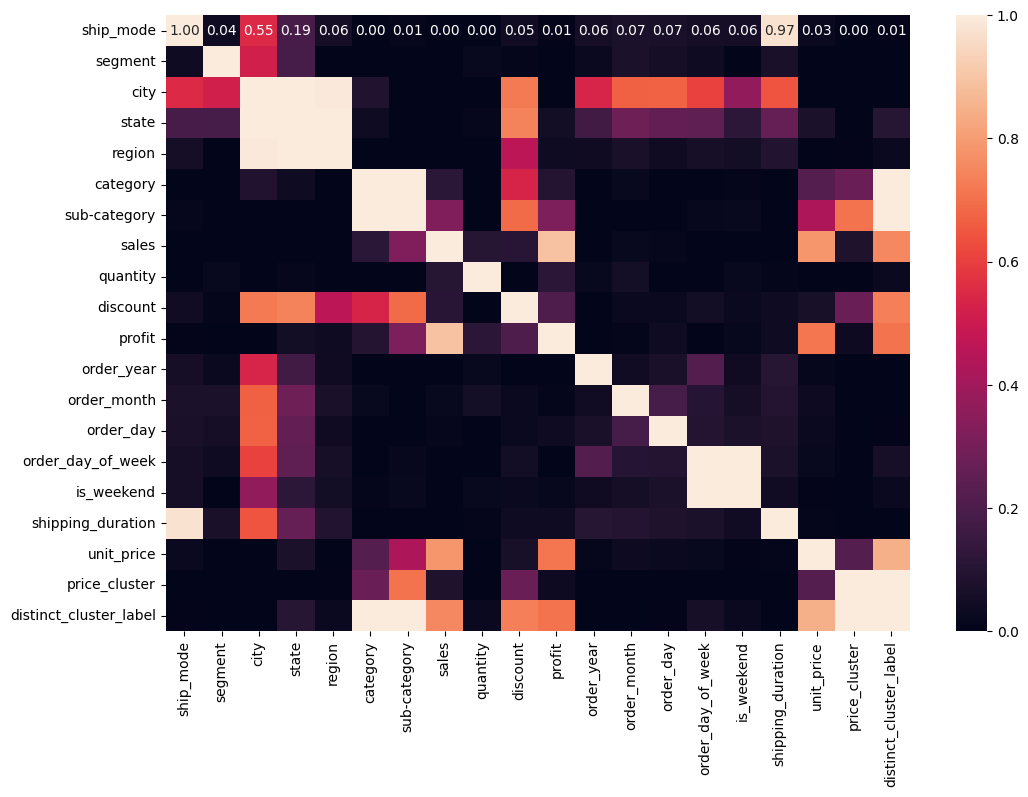

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(phik_matrix, annot=True, fmt=".2f")
plt.show()

In [ ]:
# Isolate the correlation with profit
correlation_with_profit_phik = phik_matrix['profit'].sort_values(ascending=False)
print(correlation_with_profit_phik)

profit                    1.000000
sales                     0.893351
unit_price                0.714247
distinct_cluster_label    0.704949
sub-category              0.319992
discount                  0.206762
quantity                  0.115840
category                  0.095263
state                     0.050452
order_day                 0.038294
shipping_duration         0.037399
region                    0.035284
price_cluster             0.032569
is_weekend                0.018712
order_month               0.008245
ship_mode                 0.007790
segment                   0.000000
order_year                0.000000
order_day_of_week         0.000000
city                      0.000000
Name: profit, dtype: float64


In [ ]:
# Selecting features
features = ['sales', 'unit_price', 'discount', 'quantity', 'distinct_cluster_label', 'sub-category']

# Target variable
target = 'profit'

# Splitting data into 75% train and 25% combined validation and test
X_train, X_test, y_train, y_test = train_test_split(clustered_data[features], clustered_data[target], test_size=0.25, random_state=42)


In [ ]:
n_col = X_train.select_dtypes(include = np.number).columns.tolist()  # select all the number columns and append them to n_col
c_col = X_train.select_dtypes(include = ['object']).columns.tolist() # select all the object columns and append them to c_col
print('Numerical Columns:', n_col)
print('Categorical Columns:', c_col)

Numerical Columns: ['sales', 'unit_price', 'discount', 'quantity']
Categorical Columns: ['distinct_cluster_label', 'sub-category']


In [ ]:
X_train_n = X_train[n_col] #add the values of the columns to the test and train columns
X_test_n = X_test[n_col]

X_train_c = X_train[c_col]
X_test_c = X_test[c_col]

X_train_n.head()

,sales,unit_price,discount,quantity
5199,2.304,2.304,0.2,1
4648,440.190,48.910,0.0,9
3701,15.168,7.584,0.2,2
7374,7.890,7.890,0.0,1
5237,362.940,120.980,0.0,3


In [ ]:
scaler = StandardScaler() #fit the Standard scaler and transform(scale) the numerical dataset
scaler.fit(X_train_n) 
X_train_n_scaled = scaler.transform(X_train_n)
X_test_n_scaled = scaler.transform(X_test_n)

In [ ]:
ohe = OneHotEncoder() #encode the categorical column using onehotencoder

X_train_c_encoded = ohe.fit_transform(X_train_c).toarray()
X_test_c_encoded = ohe.transform(X_test_c).toarray()

In [ ]:
X_train_final = np.concatenate([X_train_n_scaled,X_train_c_encoded], axis = 1) #combine the scaled and encoded columns
X_test_final = np.concatenate([X_test_n_scaled,X_test_c_encoded], axis = 1)

In [ ]:
xgb = xg.XGBRegressor() #Use XGB Regressor

In [ ]:
xgb.fit(X_train_final, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

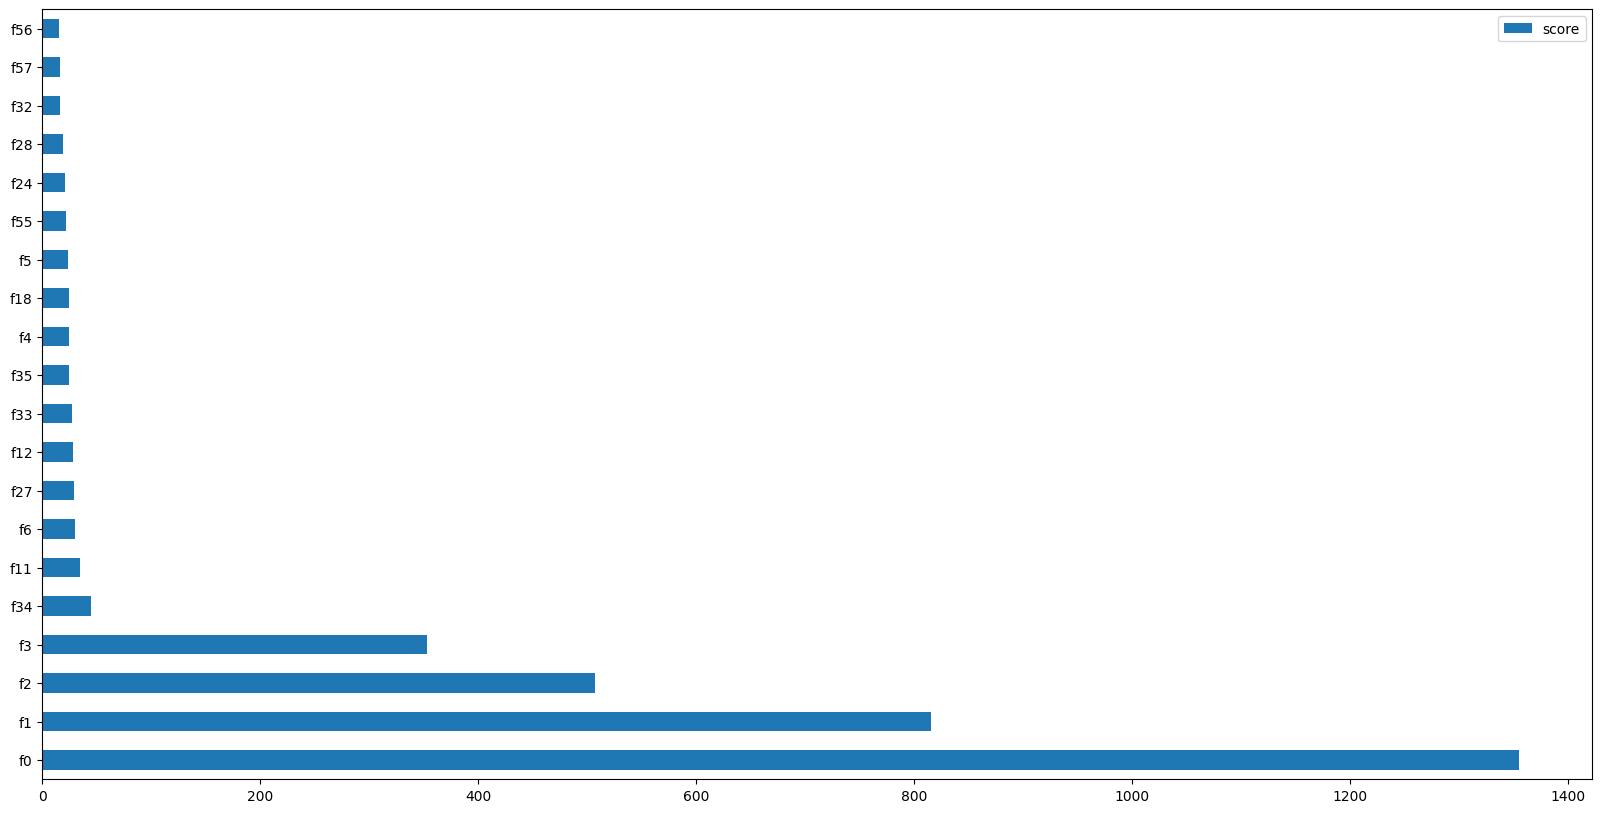

In [ ]:
feature_important = xgb.get_booster().get_score() #list the importance Score of each variable, the higher the score the more important the variable 
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10))

In [ ]:
y_pred_train = xgb.predict(X_train_final) #predict the model to the data
y_pred_test = xgb.predict(X_test_final)
y_pred_train

array([  1.1731857, 208.28227  ,   2.3743243, ...,   4.497809 ,
        10.003264 ,   8.856773 ], dtype=float32)

In [ ]:
print('R2 of Train Set : ', r2_score(y_train, y_pred_train)) #tell the R^2 and RMSE score
print('R2 of Test Set  : ', r2_score(y_test, y_pred_test))
print('RMSE Train-set:', sqrt(mean_squared_error(y_train,y_pred_train)))
print('RMSE Test-set:', sqrt(mean_squared_error(y_test,y_pred_test)))

R2 of Train Set :  0.9944144704489719
R2 of Test Set  :  0.9181995826106478
RMSE Train-set: 18.757436151795737
RMSE Test-set: 49.95590664544016


In [ ]:
clustered_data.columns

Index(['ship_mode', 'segment', 'city', 'state', 'region', 'category',
       'sub-category', 'sales', 'quantity', 'discount', 'profit', 'order_year',
       'order_month', 'order_day', 'order_day_of_week', 'is_weekend',
       'shipping_duration', 'unit_price', 'price_cluster',
       'distinct_cluster_label'],
      dtype='object')

In [ ]:
clustered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 0 to 9929
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ship_mode               9994 non-null   object 
 1   segment                 9994 non-null   object 
 2   city                    9994 non-null   object 
 3   state                   9994 non-null   object 
 4   region                  9994 non-null   object 
 5   category                9994 non-null   object 
 6   sub-category            9994 non-null   object 
 7   sales                   9994 non-null   float64
 8   quantity                9994 non-null   int64  
 9   discount                9994 non-null   float64
 10  profit                  9994 non-null   float64
 11  order_year              9994 non-null   int32  
 12  order_month             9994 non-null   int32  
 13  order_day               9994 non-null   int32  
 14  order_day_of_week       9994 non-null   int32

In [ ]:
clustered_data.head(5)

,ship_mode,segment,city,state,region,category,sub-category,sales,quantity,discount,profit,order_year,order_month,order_day,order_day_of_week,is_weekend,shipping_duration,unit_price,price_cluster,distinct_cluster_label
0,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,2016,11,8,1,0,3,130.9800,0,Bookcases_0
27,Standard Class,Consumer,Philadelphia,Pennsylvania,East,Furniture,Bookcases,3083.4300,7,0.50,-1665.0522,2015,9,17,3,0,4,440.4900,1,Bookcases_1
38,Standard Class,Home Office,Houston,Texas,Central,Furniture,Bookcases,532.3992,3,0.32,-46.9764,2015,12,27,6,1,4,177.4664,0,Bookcases_0
189,First Class,Home Office,New York City,New York,East,Furniture,Bookcases,899.1360,4,0.20,112.3920,2015,10,12,0,0,2,224.7840,0,Bookcases_0
192,First Class,Home Office,New York City,New York,East,Furniture,Bookcases,626.3520,3,0.20,46.9764,2015,10,12,0,0,2,208.7840,0,Bookcases_0


In [ ]:
df_inf = { #make new dataframe for inference
'ship_mode': 'Second Class', 
'segment': 'Consumer', 
'city': 'San Diego', 
'state':'California', 
'region':'West', 
'category':'Furniture',
'sub-category': 'Tables', 
'product_name':'Bretford CR4500 Series Slim Rectangular Table', 
'sales': 276, 
'quantity': 5,
'discount': 0.1,
'order_year':2016, 
'order_month':11, 
'order_day':8, 
'order_day_of_week':2,
'is_weekend': 1, 
'shipping_duration':7, 
'unit_price':23,
'price_cluster':1,
'distinct_cluster_label': 'Fasteners_0'
}

df_inf = pd.DataFrame([df_inf])
df_inf

,ship_mode,segment,city,state,region,category,sub-category,product_name,sales,quantity,discount,order_year,order_month,order_day,order_day_of_week,is_weekend,shipping_duration,unit_price,price_cluster,distinct_cluster_label
0,Second Class,Consumer,San Diego,California,West,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,276,5,0.1,2016,11,8,2,1,7,23,1,Fasteners_0


In [ ]:
df_inf_n = df_inf[n_col]
df_inf_c = df_inf[c_col]

In [ ]:
df_inf_n_scaled = scaler.transform(df_inf_n)
df_inf_c_encoded = ohe.transform(df_inf_c).toarray()

In [ ]:
df_inf_final = np.concatenate([df_inf_n_scaled,df_inf_c_encoded], axis = 1)

In [ ]:
y_pred_inf = xgb.predict(df_inf_final) #from the data, the profit will be 46.81
print('profit:', round(y_pred_inf[0],2))

profit: 46.81
